Very messy implementation of https://arxiv.org/pdf/2410.10103

Attempting to reproduce Coupled-Rossler analysis, with deep learning extension to learn the coordinate transforms.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import diffrax
import optax
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

from src.generator import coupled_rossler
from src.koopman import *
from src.nn import *

# Generate dynamics 
In particular, trying to replicate Fig 1b.
Since the IC is not defned in the paper, tried to approximate i.e., eye-ball from the subfigure

### Specify parameters, ICs, timestepping

In [3]:
# Time span
t0, t1 = 0.0, 10.0
dt = 0.01
steps = int((t1 - t0) / dt)

# Parameters
phi1, phi2 = 1.0, 1.0  # Frequencies
a, b, d = 0.2, 0.2, 5.7  # Rössler parameters

# Initial condition (eye-ball from the paper)
initial_state = jnp.array([1.0, -2.0, 0.0, 0.0, 0.0, 0.0])

# Coupling coefficients 
# (causal direction: Omega 2 --> Omega 1; but NOT Omega 1 --> Omega 2)
c2 = 0

### Integrate forward

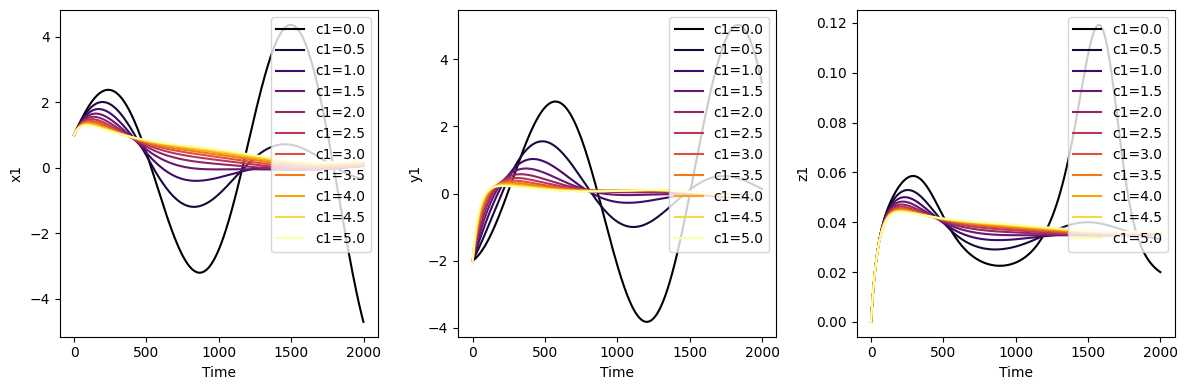

In [4]:
# Integration
solver = diffrax.Dopri5()  # Runge-Kutta solver

# Create figure
f, ax = plt.subplots(1, 3, figsize=(12, 4))

# Generate color map
c1_values = jnp.linspace(0, 5, 11)  # Coupling strength values
colors = cm.inferno(jnp.linspace(0, 1, len(c1_values)))  # Inferno colormap

for c1, color in zip(c1_values, colors):
    params = (phi1, phi2, a, b, d, c1, c2)

    # Solve the system
    solution = diffrax.diffeqsolve(
        diffrax.ODETerm(coupled_rossler),
        solver=solver,
        t0=t0,
        t1=t1,
        dt0=dt,
        y0=initial_state,
        args=params,
        saveat=diffrax.SaveAt(ts=jnp.linspace(t0, t1, 2000)),
        max_steps=100000
    )

    # Extract results (divided into omega_1, omega_2)
    omega_1, omega_2 = solution.ys.T[:3], solution.ys.T[3:]

    # Plot the results
    ax[0].plot(omega_1[0], label=f"c1={c1:.1f}", color=color)
    ax[1].plot(omega_1[1], label=f"c1={c1:.1f}", color=color)
    ax[2].plot(omega_1[2], label=f"c1={c1:.1f}", color=color)

# Add labels and legends
for i, var in enumerate(["x1", "y1", "z1"]):
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(var)
    ax[i].legend(loc="upper right")

plt.tight_layout()
plt.show()

# Causal Koopman

### Causal dependence with increasing shifts

We evaluate the temporal dependence, primarily to reproduce Figure 2.

In [5]:
# Integration
t0, t1 = 0.0, 40.0
dt = 0.01
steps = int((t1 - t0) / dt)
phi1, phi2 = 1.0, 1.0  # Frequencies
a, b, d = 0.2, 0.2, 5.7  # Rössler parameters
c1, c2 = 0.5, 0 # Coupling term
params = (phi1, phi2, a, b, d, c1, c2)

# Solve the system
solver = diffrax.Dopri5()  # Runge-Kutta solver
solution = diffrax.diffeqsolve(
    diffrax.ODETerm(coupled_rossler),
    solver=solver,
    t0=t0,
    t1=t1,
    dt0=dt,
    y0=initial_state,
    args=params,
    saveat=diffrax.SaveAt(ts=jnp.linspace(t0, t1, steps)),
    max_steps=100000
)

# Extract results (divided into omega_1, omega_2)
omega = solution.ys.T
omega_1, omega_2 = omega[:3], omega[3:]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:43<00:00,  1.08s/it]


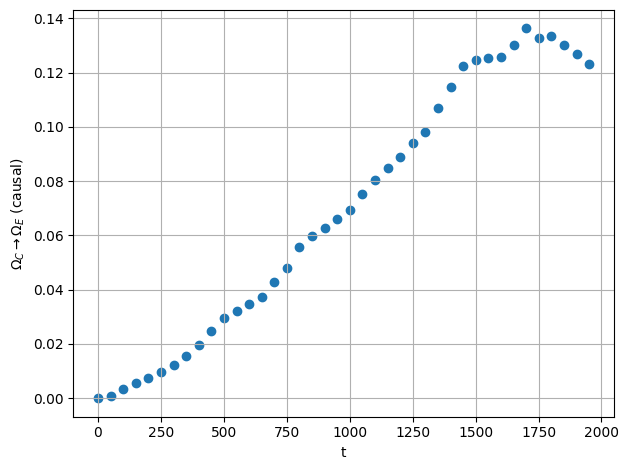

In [6]:
# Causal shifts
time_shifts = jnp.arange(1, 2000, 50)
losses = {'causal': [], 'non_causal': []}

for t in tqdm(time_shifts):
    causal_loss, _, _ = compute_causal_loss(
        cause=omega_2, 
        effect=omega_1,
        t=t
    )
    
    losses['causal'].append(causal_loss)

# Plot
plt.scatter(time_shifts, losses['causal'])
plt.xlabel('t')
plt.ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')
plt.grid()
plt.tight_layout()
plt.show;

### Conditioning forecasting
This is primarily to reproduce the algorithms introduced in Part IV section B, and Figure 4.

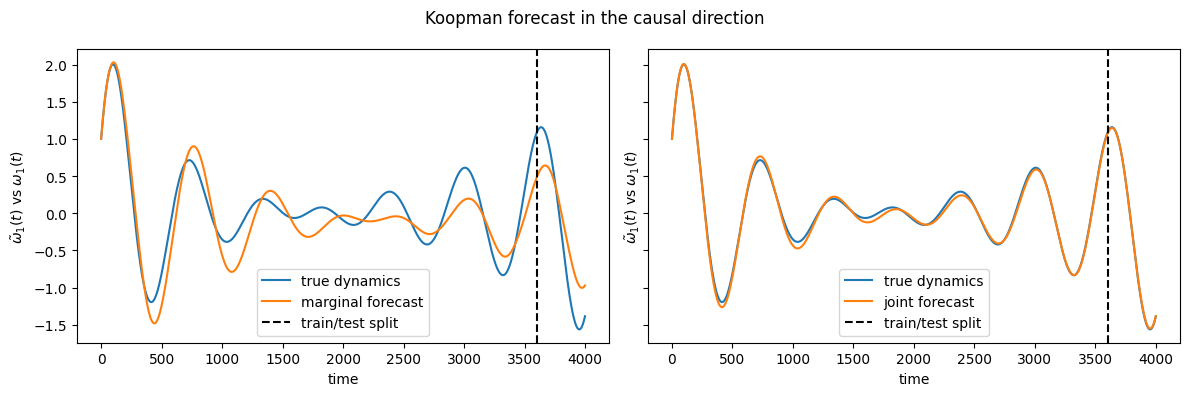

In [7]:
# Conditional inference (causal)
# Expected behavior: imperfect match in the marginal model, but perfect in joint.
cause = omega_2
effect = omega_1
n_train = int(0.9 * steps)

omega_marginal, omega_joint = conditional_forecasting(
    cause = cause, 
    effect = effect, 
    n_train = n_train, 
    t=1
)

# Plot
param_id = 0

f, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
ax[0].plot(effect[param_id], label='true dynamics')
ax[0].plot(omega_marginal[param_id], label='marginal forecast')
ax[0].axvline(n_train, color='black', linestyle='--', label='train/test split') 
ax[0].set_xlabel('time')
ax[0].set_ylabel(r'$\tilde{\omega}_1(t)$ vs $\omega_1(t)$')
ax[0].legend()

ax[1].plot(effect[param_id], label='true dynamics')
ax[1].plot(omega_joint[param_id], label='joint forecast')
ax[1].axvline(n_train, color='black', linestyle='--', label='train/test split') 
ax[1].set_xlabel('time')
ax[1].set_ylabel(r'$\tilde{\omega}_1(t)$ vs $\omega_1(t)$')
ax[1].legend()

f.suptitle('Koopman forecast in the causal direction')
plt.tight_layout()
plt.show();


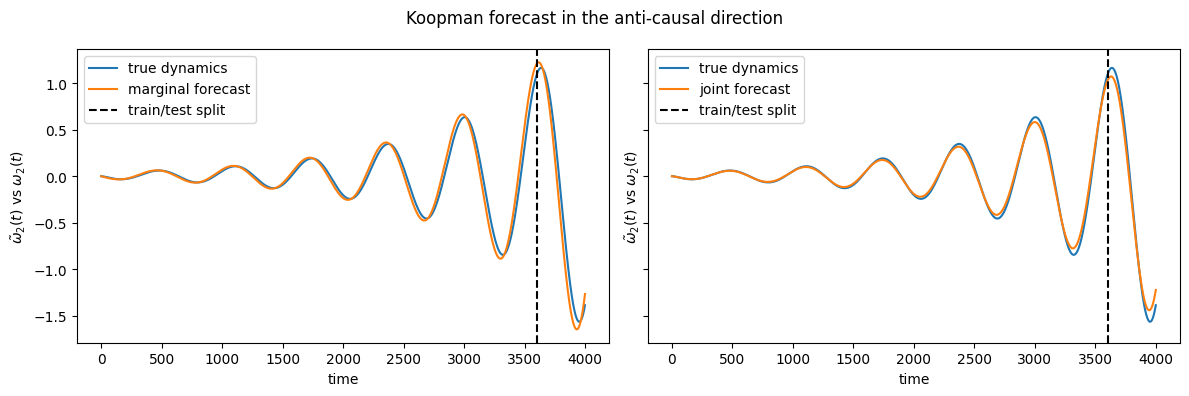

In [8]:
# Conditional inference (anti-causal)
# Expected behavior: perfect match in both models.
cause = omega_1
effect = omega_2
n_train = int(0.9 * steps)

omega_marginal, omega_joint = conditional_forecasting(
    cause = cause, 
    effect = effect, 
    n_train = n_train, 
    t=1
)

# Plot
param_id = 0

f, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
ax[0].plot(effect[param_id], label='true dynamics')
ax[0].plot(omega_marginal[param_id], label='marginal forecast')
ax[0].axvline(n_train, color='black', linestyle='--', label='train/test split') 
ax[0].set_xlabel('time')
ax[0].set_ylabel(r'$\tilde{\omega}_2(t)$ vs $\omega_2(t)$')
ax[0].legend()

ax[1].plot(effect[param_id], label='true dynamics')
ax[1].plot(omega_joint[param_id], label='joint forecast')
ax[1].axvline(n_train, color='black', linestyle='--', label='train/test split') 
ax[1].set_xlabel('time')
ax[1].set_ylabel(r'$\tilde{\omega}_2(t)$ vs $\omega_2(t)$')
ax[1].legend()

f.suptitle('Koopman forecast in the anti-causal direction')
plt.tight_layout()
plt.show();


# Deep Causal Koopman
Using neural network (encoder-decoder) to approximate the lifting operators, i.e., y(t) = f[x(t)], where x(t) is the high-dimensional non-linear states, and y(t) is the functional.

In [9]:
# Hyperparameters
t = 1
n_train = int(0.2 * steps)
hidden_dims = [6,6]
lr = 1e-3
epochs = 1000

In [10]:
@jax.jit
def loss_fn(model, x, y):
    """Reconstruction loss."""
    y_pred = model.decoder(model.encoder(x))
    return jnp.mean(jnp.square(y_pred - y))

@jax.jit
def train_step(model, opt_state, x, y):
    """Autograd routine."""
    loss, grads = jax.value_and_grad(loss_fn)(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss


def train_model(model, x, y, n_train, epochs, lr, t=1):
    """Utility function for training."""
    opt_state = optimizer.init(model)
    x, y = x[:, :n_train], y[:, :n_train]
    
    losses = []
    for epoch in range(epochs):
        model, opt_state, loss = train_step(
            model, opt_state, 
            x = x[:, :-t], y = y[:, :-t]
        )
        
        losses.append(loss)

    return model, losses

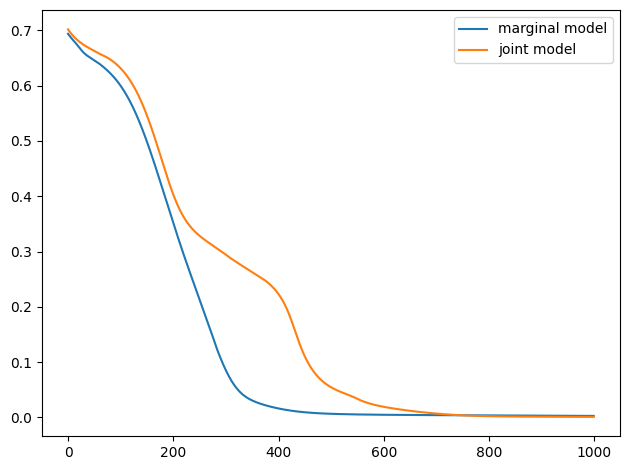

In [11]:
# Construct dataset
cause = omega_2
effect = omega_1
effect_cause = jnp.concatenate([effect, cause], axis=0)

# Define model
optimizer = optax.adamw(learning_rate=lr)
marginal_model = NNTransformModel(input_dim=effect.shape[0], hidden_dims=hidden_dims, output_dim=effect.shape[0])
joint_model = NNTransformModel(input_dim=effect_cause.shape[0], hidden_dims=hidden_dims, output_dim=effect.shape[0])

# Fit models
marginal_model, marginal_loss = train_model(
    marginal_model, x=effect, y=effect, n_train=n_train, epochs=epochs, lr=lr, t=1
)

joint_model, joint_loss = train_model(
    joint_model, x=effect_cause, y=effect, n_train=n_train, epochs=epochs, lr=lr, t=1
)

# Plot loss
plt.plot(marginal_loss, label='marginal model')
plt.plot(joint_loss, label='joint model')
plt.legend()
plt.tight_layout()
plt.show();

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.37it/s]


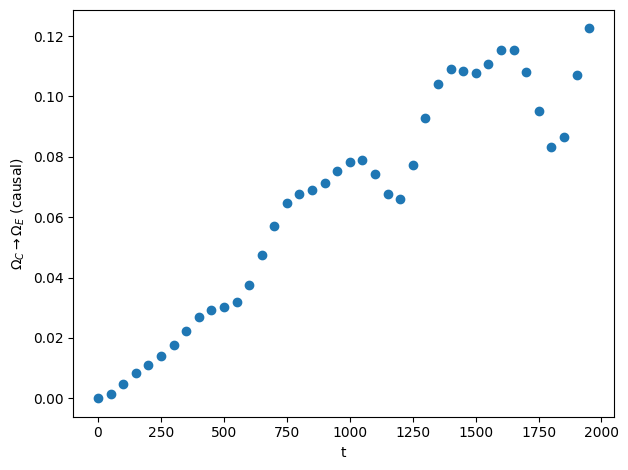

In [12]:
# Causal and non-causal direction (estimated by the causal loss)
time_shifts = jnp.arange(1, 2000, 50)
losses = {'causal': [], 'non_causal': []}

for t in tqdm(time_shifts):
    
    causal_loss, _, _ = compute_causal_loss(
        cause = cause, 
        effect = effect,
        t = t,
        marginal_model = marginal_model,
        joint_model = joint_model
    )
    
    losses['causal'].append(causal_loss)

# Plot
plt.scatter(time_shifts, losses['causal'])
plt.xlabel('t')
plt.ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')
plt.tight_layout()
plt.show;

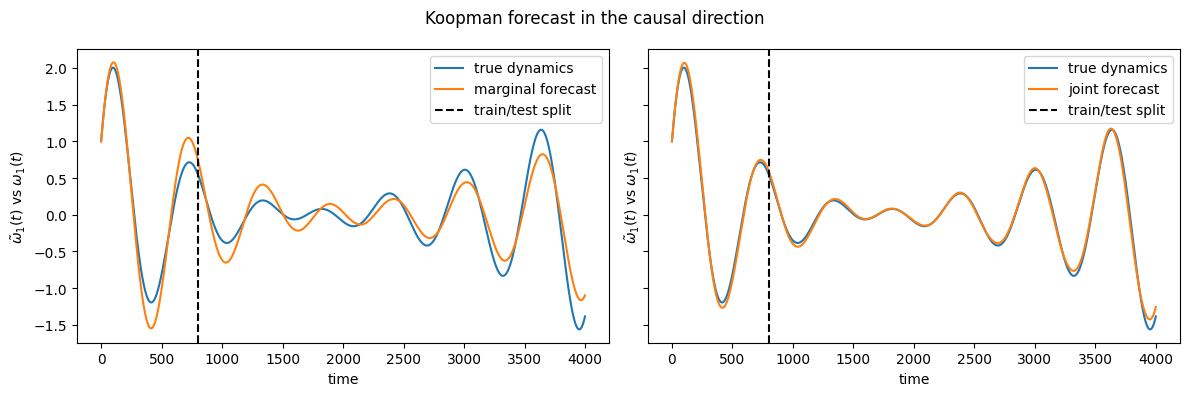

In [13]:
# Conditional inference (causal)
omega_marginal, omega_joint = conditional_forecasting(
    cause = cause, 
    effect = effect, 
    t = 1,
    marginal_model = marginal_model,
    joint_model = joint_model
)

# Plot
param_id = 0

f, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
ax[0].plot(effect[param_id], label='true dynamics')
ax[0].plot(omega_marginal[param_id], label='marginal forecast')
ax[0].axvline(n_train, color='black', linestyle='--', label='train/test split') 
ax[0].set_xlabel('time')
ax[0].set_ylabel(r'$\tilde{\omega}_1(t)$ vs $\omega_1(t)$')
ax[0].legend()

ax[1].plot(effect[param_id], label='true dynamics')
ax[1].plot(omega_joint[param_id], label='joint forecast')
ax[1].axvline(n_train, color='black', linestyle='--', label='train/test split') 
ax[1].set_xlabel('time')
ax[1].set_ylabel(r'$\tilde{\omega}_1(t)$ vs $\omega_1(t)$')
ax[1].legend()

f.suptitle('Koopman forecast in the causal direction')
plt.tight_layout()
plt.show();
